In [8]:
using DifferentialEquations, QuadGK, Plots, Latexify, LaTeXStrings, LinearAlgebra, ForwardDiff, Roots

In [2]:
Mₚ = 1.22*10. ^22; # In MeV

In [3]:
abstract type Particle end

struct Boson <: Particle
    name::String
    mass::Real
    spin::Int64
    dofs::Int64
end

struct Fermion <: Particle
    name::String
    mass::Real
    spin::Rational
    dofs::Int64
end

gstarᵨ(P::Particle, T::Real) = 15P.dofs/π^4*quadgk(y -> sqrt(y^2 - (P.mass/T)^2)*y^2/(exp(y) - (-1)^(2*P.spin)), P.mass/T, Inf)[1]
gstarₚ(P::Particle, T::Real) = 15P.dofs/π^4*quadgk(y -> (y^2 - (P.mass/T)^2)^1.5/(exp(y) - (-1)^(2*P.spin)), P.mass/T, Inf)[1]
gstarₛ(P::Particle, T::Real) = 0.75gstarᵨ(P::Particle, T::Real) + 0.25gstarₚ(P::Particle, T::Real);

In [4]:
abstract type ParticleSector end

struct StandardModel <: ParticleSector
    Tc::Real
    Tν::Real
end

function particle_content(SM::StandardModel, T::Real)
    @assert T >=0 "Temperature has to be a non-negative real number"
    if 0 <= T < SM.Tc
        [Boson("Photon", 0., 1, 2), Boson("Pions", 138., 0, 3), Boson("Kaons", 494., 0, 4), Boson("η meson", 547., 0, 1), Boson("ρ mesons", 775., 1, 9),
        Boson("ω mesons", 782., 1, 3), Boson("K* mesons", 892., 1, 12),
        Fermion("Neutrinos", 0., 1//2, 6), Fermion("Electron", 0.511, 1//2, 4), Fermion("Muon", 104., 1//2, 4), Fermion("Proton", 938., 1//2, 4),
        Fermion("Neutron", 938., 1//2, 4)]
    else
        [Boson("Photon", 0., 1, 2), Boson("Gluons", 0., 1, 16), Boson("W bosons", 8.04e4, 1, 6), Boson("Z boson", 9.118e4, 1, 3), Boson("Higgs boson", 1.25e5, 0, 1),
        Fermion("Neutrinos", 0., 1//2, 6), Fermion("Electron", 0.511, 1//2, 4), Fermion("Muon", 104., 1//2, 4), Fermion("Tau", 1.78e3, 1//2, 4), Fermion("Up quark", 1.9, 1//2, 12),
        Fermion("Down quark", 4.4, 1//2, 12), Fermion("Strange quark", 95., 1//2, 12), Fermion("Charm quark", 1.275e3, 1//2, 12), Fermion("Bottom quark", 4.24e3, 1//2, 12),
        Fermion("Top quark", 1.727e5, 1//2, 12)]
    end
end

gstarᵨ(SM::StandardModel) = function(T::Real) T > SM.Tν ? sum([gstarᵨ(particle, T) for particle in particle_content(SM, T)]) : 3.36264 end
gstarₚ(SM::StandardModel) = function(T::Real) T > SM.Tν ? sum([gstarₚ(particle, T) for particle in particle_content(SM, T)]) : 3.36264 end
gstarₛ(SM::StandardModel) = function(T::Real) T > SM.Tν ? sum([gstarₛ(particle, T) for particle in particle_content(SM, T)]) : 3.90909 end;

In [5]:
TcSM, TνSM = 150., 0.1  # In MeV

Ts = 10 .^collect(-3:0.001:7)
gstarᵨs = gstarᵨ(StandardModel(TcSM, TνSM)).(Ts)

plot(Ts, gstarᵨs, xaxis=:log10, yaxis=:log10, xflip=true, legend=false, xlabel=latexify("T")*" (MeV)", ylabel=L"g_{*, \rho}", ylim=(1, 120), minorticks=10)

UndefVarError: UndefVarError: quadgk not defined

In [6]:
struct PureSUₙ <: ParticleSector
    N::Int64
    Λ::Real
    Tc::Real
    a::Vector   # [a₀, a₁, a₂, a₃, a₄] for SU(3)
    b::Vector   # [b₃, b₄] for SU(3)
end

Vgb(SUN::PureSUₙ) = function(ϕ::Real) ϕ^4/2^10*(2log(abs(ϕ)/SUN.Λ) - 5log(2)) + SUN.Λ^4/(2ℯ) end
Vₜ(SUN::PureSUₙ) = function(ϕ::Real, T::Real) 0. end

b₂(SUN::PureSUₙ) = function(T::Real)
    Tratios = [(SUN.Tc/T)^i for i in 0:4]
    dot(SUN.a, Tratios)
end
l(SUN::PureSUₙ) = function(c₁::Real = 1)
    function(ϕ::Real, T::Real) T < SUN.Tc ? 0. : (48*SUN.b[1] + sqrt(48. ^2*SUN.b[1]^2 + 2. ^10*b₂(SUN)(T)*SUN.b[2] - 2SUN.b[2]*c₁*(ϕ/T)^4))/(64*SUN.b[2]) end
end
Vl(SUN::PureSUₙ) = function(c₁::Real = 1)
    function(ϕ::Real, T::Real) -0.5b₂(SUN)(T)*l(SUN)(c₁)(ϕ, T)^2 + SUN.b[2]*l(SUN)(c₁)(ϕ, T)^4 - 2SUN.b[1]*l(SUN)(c₁)(ϕ, T)^3 end
end
Pl(SUN::PureSUₙ) = function(c₁::Real = 1)
    function(ϕ::Real, T::Real) c₁*l(SUN)(c₁)(ϕ, T)^2 end
end

V(SUN::PureSUₙ) = function(c₁::Real = 1)
    function(ϕ::Real, T::Real) Vgb(SUN)(ϕ) + Vₜ(SUN)(ϕ, T) + ϕ^4/2^10*Pl(SUN)(c₁)(ϕ, T) + T^4*Vl(SUN)(c₁)(ϕ, T) end
end;

In [21]:
ΛSU3 = 100. # In MeV
ΛSU3 = Mₚ
TcSU3 = 1.5*ΛSU3
aSU3 = [3.72, -5.73, 8.49, -9.29, 0.27]
bSU3 = [2.40, 4.53]

MySUN = PureSUₙ(3, ΛSU3, TcSU3, aSU3, bSU3);

In [22]:
Tmin, Tmax = 0.1*MySUN.Tc, 10*MySUN.Tc

ϕs = collect(1e-3:0.1:2^2.5*MySUN.Λ/ℯ^0.25)
plot()

for T in 10 .^collect(log10(Tmin):0.1:log10(Tmax))
    plot!(ϕs/MySUN.Λ, (V(MySUN)().(ϕs, T) .- minimum(V(MySUN)().(ϕs, T)))/MySUN.Λ^4, xlabel=L"\varphi/\Lambda", ylabel=L"V(\varphi)/\Lambda^4", color="gray", label=false)
end

plot!(ϕs/MySUN.Λ, Vgb(MySUN).(ϕs)/MySUN.Λ^4, xlabel=L"\varphi/\Lambda", label=L"V_{gb}(\varphi)/\Lambda^4", linestyle=:dash, linewidth=3)

for T in [15, 75, 150, 200, 250, 375, 750, 1500.]
    plot!(ϕs/MySUN.Λ, (V(MySUN)().(ϕs, T) .- minimum(V(MySUN)().(ϕs, T)))/MySUN.Λ^4, xlabel=L"\varphi/\Lambda", ylabel=L"V(\varphi)/\Lambda^4", label=L"$T = $"*string(round(T/MySUN.Tc, digits=2))*L" $T_c$")
end

plot!()

InexactError: InexactError: trunc(Int64, 5.374786273455074e23)

In [23]:
ϕ₀ = find_zero(x -> ForwardDiff.derivative(ϕ -> V(MySUN)()(ϕ, Tmax), x), 3*MySUN.Λ)

3.3356571124564333e22

In [10]:
# function f(dζ, ζ, tildeT, c₁)
#     tildeϕ, tildeξ = ζ
#     tilde∂ϕV = ForwardDiff.derivative(ϕ -> V(MySUN)(c₁)(ϕ, sqrt(Mₚ*MySUN.Λ)*tildeT), MySUN.Λ*tildeϕ)/MySUN.Λ^3

#     dζ[1] = tildeξ
#     dζ[2] = -tilde∂ϕV/(2.76*gstarᵨ(StandardModel(TcSM, TνSM))(sqrt(Mₚ*MySUN.Λ)*tildeT)*tildeT^6)
# end;

In [24]:
tildeTi = Tmax/MySUN.Λ

function f(dζ, ζ, η, c₁)
    tildeϕ, tildeξ = ζ
    tilde∂ϕV = ForwardDiff.derivative(ϕ -> V(MySUN)(c₁)(ϕ, MySUN.Λ*(tildeTi - MySUN.Λ*η/Mₚ)), MySUN.Λ*tildeϕ)/MySUN.Λ^3

    dζ[1] = tildeξ
    dζ[2] = -tilde∂ϕV/(2.76*gstarᵨ(StandardModel(TcSM, TνSM))(MySUN.Λ*(tildeTi - MySUN.Λ*η/Mₚ))*(tildeTi - MySUN.Λ*η/Mₚ)^6)
end;

In [28]:
u0, c₁ = [ϕ₀/MySUN.Λ, 0.], 1
ηspan = (0, 1e7)
problem = ODEProblem(f, u0, ηspan, c₁);

In [29]:
sol = solve(problem)

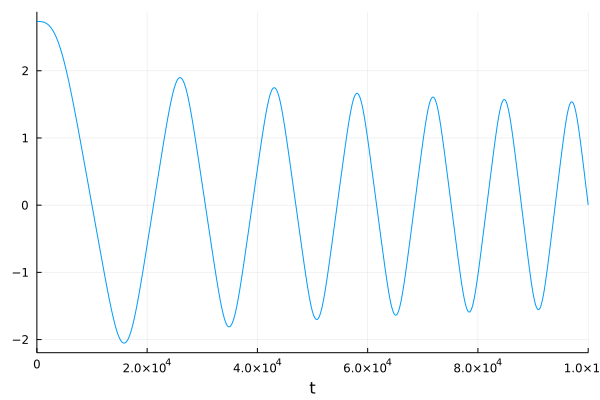

In [27]:
plot(sol, vars=(1), legend=false)